# Challenge 3: Artifical Neural Networks

<a target="_blank" href="https://colab.research.google.com/github/LucaPennella/Intro_to_ML_23-24/blob/main/challenges/challenge-three.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


Using Fully Connected Neural Networks and Convolutional Neural Networks, perform the following tasks on [KMNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.KMNIST.html#torchvision.datasets.KMNIST).
1. Data exploration.
    * Provide a grid plot of the first 10/12 examples with associated labels
    * Split using the provided pytorch objects into train/validation/test sets
2. For each architecture, tune the number of the hidden layers ($\le 3$), the optimizer, and some hyperparameters of your choice. How many tries to do is up to your discretion. Discuss the choice you made in the report.
3. Summarise your results in a table and comment on them in the report. 
4. For a model (not necessarily the best performing one), plot training loss vs testing loss and training accuracy vs testing accuracy, and comment on what you see.
    * Beyond accuracy provide the confusion matrix for the model outputs. Discuss differences between train/validation/test sets. Is accuracy a good metric in this case why or why not?

In [1]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import torchvision

In [2]:
print(torch.cuda.is_available())


True


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.rand(5,5).to(device)
x

tensor([[0.3128, 0.7355, 0.2678, 0.8890, 0.8848],
        [0.2391, 0.5377, 0.0570, 0.4579, 0.9294],
        [0.7279, 0.0737, 0.4536, 0.5269, 0.5097],
        [0.9788, 0.2934, 0.0475, 0.2071, 0.4656],
        [0.5932, 0.4348, 0.8581, 0.3123, 0.0753]], device='cuda:0')

# 1. Data Eploration

In [1]:
from torchvision.datasets import KMNIST
from torchvision import transforms

transform = transforms.ToTensor()
train_set = KMNIST(root='./data', train=True, download=True, transform=transform)
test_set = KMNIST(root='./data', train=False, download=True, transform=transform)


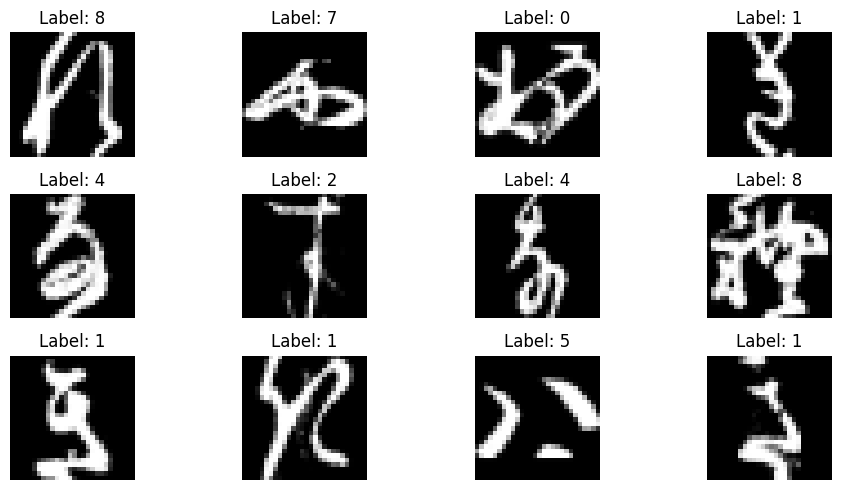

In [4]:
fig, axes = plt.subplots(3, 4, figsize=(10, 5))
for i in range(12):
    ax = axes[i // 4, i % 4]
    ax.imshow(train_set.data[i], cmap='gray')
    ax.set_title(f"Label: {train_set.targets[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()


In [5]:
from torch.utils.data import random_split, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = torch.Generator().manual_seed(0)

train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size
train_subset, val_subset = random_split(train_set, [train_size, val_size],  generator=generator)

# 2. Architecture Exploration

In [6]:
import torch.nn as nn

class FCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.model(x)


In [7]:

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.model(x)


In [8]:

batch_train_subset = DataLoader(train_subset, batch_size=64, shuffle=True)
batch_val_subset = DataLoader(val_subset, batch_size=64, shuffle=True)
batch_test_set = DataLoader(test_set, batch_size=64, shuffle=False)


In [9]:

results = []
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


In [10]:
def log_result_epoch(model_type, hidden_layers, optimizer_name, lr, batch_size,
                     dropout, weight_decay, train_loss, val_loss,
                     train_acc, val_acc, epoch):
    results.append({
        'Epoch': epoch,
        'Model Type': model_type,
        'Hidden Layers': hidden_layers,
        'Optimizer': optimizer_name,
        'Learning Rate': lr,
        'Batch Size': batch_size,
        'Dropout': dropout,
        'Weight Decay': weight_decay,
        'Train Loss': round(train_loss, 4),
        'Val Loss': round(val_loss, 4),
        'Train Accuracy (%)': round(train_acc * 100, 2),
        'Val Accuracy (%)': round(val_acc * 100, 2),
    })


In [13]:

from torch.utils.tensorboard import SummaryWriter


In [14]:

def train_and_log_each_epoch(model, model_type, hidden_layers, optimizer, optimizer_name,
                              lr, batch_size, dropout, weight_decay,
                              train_loader, val_loader, device, writer):

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    best_val_acc = 0.0

    for epoch in range(10):
        model.train()
        total_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        avg_train_loss = total_train_loss / len(train_loader)
        train_acc = correct_train / total_train

        # Validation
        model.eval()
        total_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        avg_val_loss = total_val_loss / len(val_loader)
        val_acc = correct_val / total_val

        # Log to TensorBoard
        writer.add_scalar(f'Loss/train', avg_train_loss, epoch)
        writer.add_scalar(f'Loss/validation', avg_val_loss, epoch)
        writer.add_scalar(f'Acc/train', train_acc, epoch)
        writer.add_scalar(f'Acc/validation', val_acc, epoch)

        save_name = f"{model_type}_epoch{epoch+1}_{optimizer_name}.pth"
        torch.save(model.state_dict(), save_name)

        # Optionally save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_name = f"best_{model_type}_{optimizer_name}.pth"
            torch.save(model.state_dict(), best_model_name)

        # Append results
        results.append({
            'Epoch': epoch + 1,
            'Model Type': model_type,
            'Hidden Layers': hidden_layers,
            'Optimizer': optimizer_name,
            'Learning Rate': lr,
            'Batch Size': batch_size,
            'Dropout': dropout,
            'Weight Decay': weight_decay,
            'Train Loss': avg_train_loss,
            'Val Loss': avg_val_loss,
            'Train Accuracy (%)': round(train_acc * 100, 2),
            'Val Accuracy (%)': round(val_acc * 100, 2),
            'Notes': 'Optimizer test run'
        })



In [15]:
device

device(type='cpu')

In [15]:
# Best hyperparameters per model and optimizer
best_hyperparams = {
    'CNN': {
        'Adam':     {'lr': 0.001, 'weight_decay': 1e-5},
        'SGD':      {'lr': 0.1,   'momentum': 0.9},
        'RMSprop':  {'lr': 0.001, 'weight_decay': 1e-5}
    },
    'FCNN': {
        'Adam':     {'lr': 0.001, 'weight_decay': 1e-5},
        'SGD':      {'lr': 0.1,   'momentum': 0.9},
        'RMSprop':  {'lr': 0.001, 'weight_decay': 1e-5}
    }
}

models = [FCNN, CNN]
df = {}
img_grid = {}

for model_class in models:
    model_name = model_class.__name__
    writer = SummaryWriter(log_dir=f'runs/{model_name}')

    # log image grid
    dataiter = iter(batch_train_subset)
    images, labels = next(dataiter)
    img_grid[model_name] = torchvision.utils.make_grid(images)
    writer.add_image(f'{model_name}_sample_images', img_grid[model_name])

    for opt_name in ['Adam', 'SGD', 'RMSprop']:
        model = model_class()
        hp = best_hyperparams[model_name][opt_name]

        if opt_name == 'Adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=hp['lr'], weight_decay=hp['weight_decay'])
            wd = hp['weight_decay']
        elif opt_name == 'SGD':
            optimizer = torch.optim.SGD(model.parameters(), lr=hp['lr'], momentum=hp['momentum'])
            wd = 0.0  # not using weight_decay in SGD here
        elif opt_name == 'RMSprop':
            optimizer = torch.optim.RMSprop(model.parameters(), lr=hp['lr'], weight_decay=hp['weight_decay'])
            wd = hp['weight_decay']

        results = []

        train_and_log_each_epoch(
            model=model,
            model_type=model_name,
            hidden_layers="256 → 128",
            optimizer=optimizer,
            optimizer_name=opt_name,
            lr=hp['lr'],
            batch_size=64,
            dropout=0.2,
            weight_decay=wd,
            train_loader=batch_train_subset,
            val_loader=batch_val_subset,
            device=device,
            writer=writer
        )

        if model_name in df:
            df[model_name] = pd.concat([df[model_name], pd.DataFrame(results)], ignore_index=True)
        else:
            df[model_name] = pd.DataFrame(results)

    writer.flush()
    writer.close()


# 4. Adam Exploration

In [16]:
df_CNN_only = df['CNN'][df['CNN']['Model Type'] == 'CNN']

In [17]:
df_CNN_only

,Epoch,Model Type,Hidden Layers,Optimizer,Learning Rate,Batch Size,Dropout,Weight Decay,Train Loss,Val Loss,Train Accuracy (%),Val Accuracy (%),Notes
0,1,CNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.339746,0.126339,89.61,96.03,Optimizer test run
1,2,CNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.109398,0.084469,96.69,97.39,Optimizer test run
2,3,CNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.071338,0.059900,97.83,98.08,Optimizer test run
3,4,CNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.049995,0.056157,98.38,98.32,Optimizer test run
4,5,CNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.037210,0.057461,98.77,98.17,Optimizer test run
5,6,CNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.028247,0.061208,99.01,98.33,Optimizer test run
6,7,CNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.023498,0.057308,99.19,98.33,Optimizer test run
7,8,CNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.019089,0.055305,99.36,98.38,Optimizer test run
8,9,CNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.017221,0.057391,99.41,98.36,Optimizer test run
9,10,CNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.015495,0.054247,99.49,98.52,Optimizer test run


In [29]:
df_CNN_only[df_CNN_only['Optimizer'] == 'Adam']


,Epoch,Model Type,Hidden Layers,Optimizer,Learning Rate,Batch Size,Dropout,Weight Decay,Train Loss,Val Loss,Train Accuracy (%),Val Accuracy (%),Notes
0,1,CNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.339746,0.126339,89.61,96.03,Optimizer test run
1,2,CNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.109398,0.084469,96.69,97.39,Optimizer test run
2,3,CNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.071338,0.059900,97.83,98.08,Optimizer test run
3,4,CNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.049995,0.056157,98.38,98.32,Optimizer test run
4,5,CNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.037210,0.057461,98.77,98.17,Optimizer test run
5,6,CNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.028247,0.061208,99.01,98.33,Optimizer test run
6,7,CNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.023498,0.057308,99.19,98.33,Optimizer test run
7,8,CNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.019089,0.055305,99.36,98.38,Optimizer test run
8,9,CNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.017221,0.057391,99.41,98.36,Optimizer test run
9,10,CNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.015495,0.054247,99.49,98.52,Optimizer test run


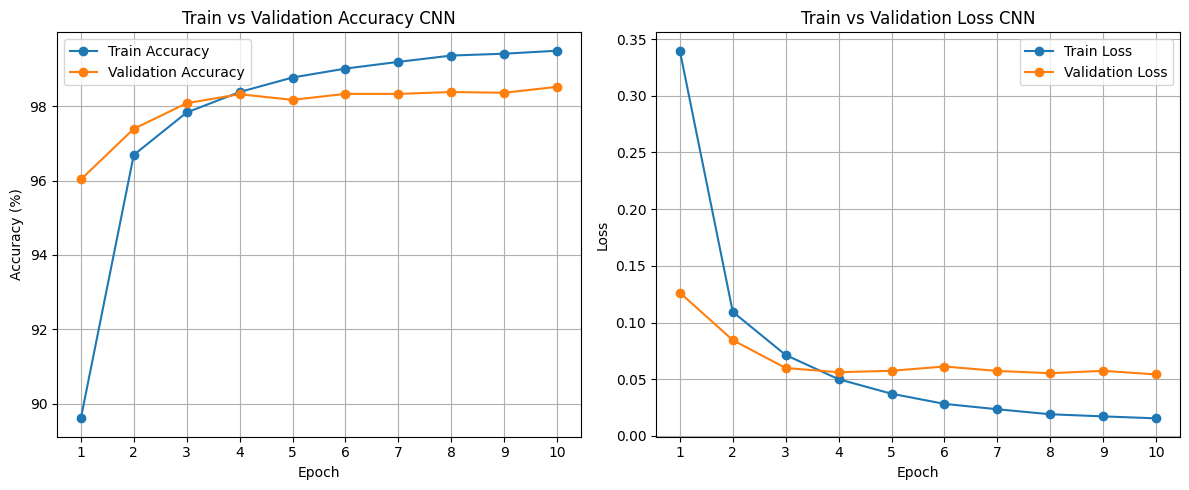

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

epochs = df_CNN_only[df_CNN_only['Optimizer'] == 'Adam']['Epoch']
Train_Accuracy_CNN = df_CNN_only[df_CNN_only['Optimizer'] == 'Adam']['Train Accuracy (%)']
Validation_Accuracy_CNN = df_CNN_only[df_CNN_only['Optimizer'] == 'Adam']['Val Accuracy (%)']

# Accuracy plot with different y-axes
ax[0].plot(epochs, Train_Accuracy_CNN, label='Train Accuracy', marker='o')
ax[0].plot(epochs, Validation_Accuracy_CNN, label='Validation Accuracy', marker='o')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy (%)')
ax[0].set_title('Train vs Validation Accuracy CNN')
ax[0].legend()
ax[0].grid(True)

ax[0].set_xticks(epochs)

Train_Loss_CNN =  df_CNN_only[df_CNN_only['Optimizer'] == 'Adam']['Train Loss']
Validation_Loss_CNN = df_CNN_only[df_CNN_only['Optimizer'] == 'Adam']['Val Loss']

# Loss plot with different y-axes
ax[1].plot(epochs, Train_Loss_CNN, label='Train Loss', marker='o')
ax[1].plot(epochs, Validation_Loss_CNN, label='Validation Loss', marker='o')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Train vs Validation Loss CNN')
ax[1].legend()
ax[1].grid(True)

ax[1].set_xticks(epochs)

plt.tight_layout()
plt.show()


In [20]:
df_FCNN_only = df['FCNN'][df['FCNN']['Model Type'] == 'FCNN']

In [21]:
df_FCNN_only

,Epoch,Model Type,Hidden Layers,Optimizer,Learning Rate,Batch Size,Dropout,Weight Decay,Train Loss,Val Loss,Train Accuracy (%),Val Accuracy (%),Notes
0,1,FCNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.600266,0.328950,81.84,89.86,Optimizer test run
1,2,FCNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.317590,0.244219,90.34,92.73,Optimizer test run
2,3,FCNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.242361,0.204358,92.60,93.81,Optimizer test run
3,4,FCNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.198034,0.189875,93.93,94.42,Optimizer test run
4,5,FCNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.172141,0.174427,94.77,94.75,Optimizer test run
5,6,FCNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.152570,0.163161,95.27,95.15,Optimizer test run
6,7,FCNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.138608,0.169199,95.70,95.07,Optimizer test run
7,8,FCNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.121565,0.159785,96.22,95.36,Optimizer test run
8,9,FCNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.116292,0.162612,96.17,95.38,Optimizer test run
9,10,FCNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.106740,0.161209,96.62,95.40,Optimizer test run


In [22]:
df_FCNN_only[df_FCNN_only['Optimizer'] == 'Adam']


,Epoch,Model Type,Hidden Layers,Optimizer,Learning Rate,Batch Size,Dropout,Weight Decay,Train Loss,Val Loss,Train Accuracy (%),Val Accuracy (%),Notes
0,1,FCNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.600266,0.328950,81.84,89.86,Optimizer test run
1,2,FCNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.317590,0.244219,90.34,92.73,Optimizer test run
2,3,FCNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.242361,0.204358,92.60,93.81,Optimizer test run
3,4,FCNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.198034,0.189875,93.93,94.42,Optimizer test run
4,5,FCNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.172141,0.174427,94.77,94.75,Optimizer test run
5,6,FCNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.152570,0.163161,95.27,95.15,Optimizer test run
6,7,FCNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.138608,0.169199,95.70,95.07,Optimizer test run
7,8,FCNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.121565,0.159785,96.22,95.36,Optimizer test run
8,9,FCNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.116292,0.162612,96.17,95.38,Optimizer test run
9,10,FCNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.106740,0.161209,96.62,95.40,Optimizer test run


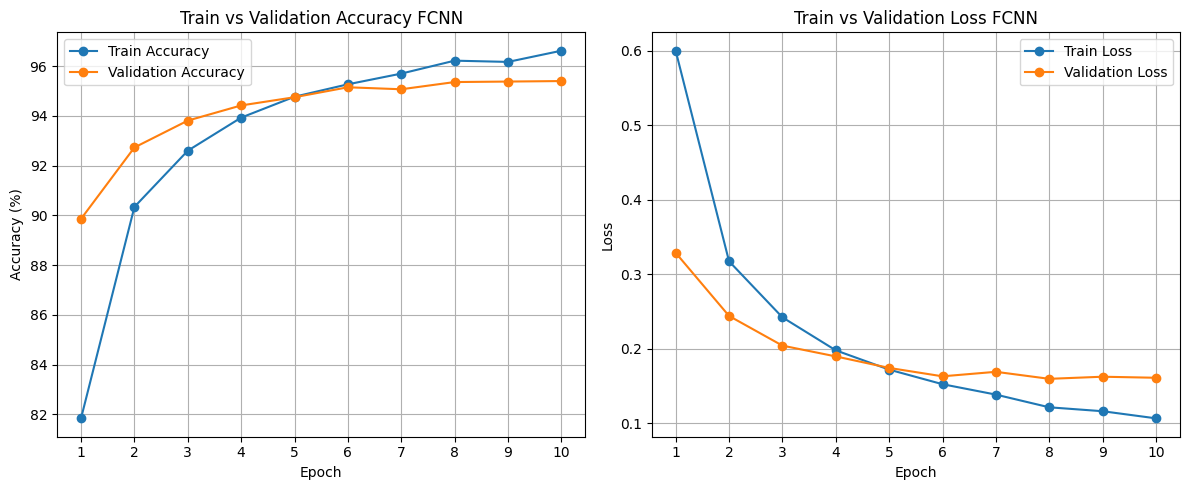

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

epochs = df_FCNN_only[df_FCNN_only['Optimizer'] == 'Adam']['Epoch']
Train_Accuracy_FCNN = df_FCNN_only[df_FCNN_only['Optimizer'] == 'Adam']['Train Accuracy (%)']
Validation_Accuracy_FCNN = df_FCNN_only[df_FCNN_only['Optimizer'] == 'Adam']['Val Accuracy (%)']

# Accuracy plot with different y-axes
ax[0].plot(epochs, Train_Accuracy_FCNN, label='Train Accuracy', marker='o')
ax[0].plot(epochs, Validation_Accuracy_FCNN, label='Validation Accuracy', marker='o')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy (%)')
ax[0].set_title('Train vs Validation Accuracy FCNN')
ax[0].legend()
ax[0].grid(True)

ax[0].set_xticks(epochs)

Train_Loss_FCNN =  df_FCNN_only[df_FCNN_only['Optimizer'] == 'Adam']['Train Loss']
Validation_Loss_CNN = df_FCNN_only[df_FCNN_only['Optimizer'] == 'Adam']['Val Loss']

# Loss plot with different y-axes
ax[1].plot(epochs, Train_Loss_FCNN, label='Train Loss', marker='o')
ax[1].plot(epochs, Validation_Loss_CNN, label='Validation Loss', marker='o')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Train vs Validation Loss FCNN')
ax[1].legend()
ax[1].grid(True)

ax[1].set_xticks(epochs)

plt.tight_layout()
plt.show()


In [24]:
def get_batch_accuracy(logit, target):
    corrects = (torch.max(logit,1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100 * corrects / target.size(0)
    return accuracy.item()

In [49]:
def evaluate(model, val_loader, device):
    model.eval()
    test_acc = 0.0

    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader, 0):
            outputs = model(images)
            test_acc += get_batch_accuracy(outputs, labels)
    return test_acc / i

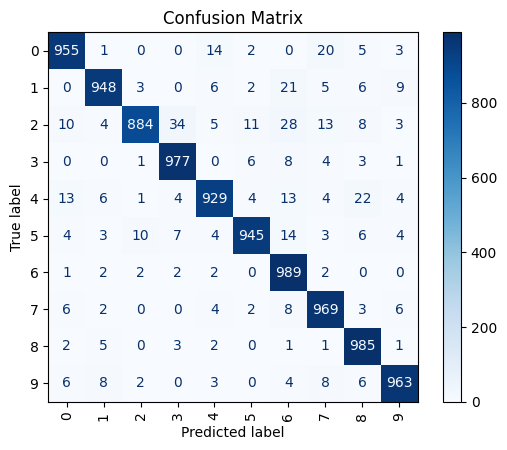

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model = CNN()  # or FCNN()
model.load_state_dict(torch.load("best_CNN_Adam.pth"))

model.to(device)
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in batch_test_set:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()


In [52]:
test_accuracy = evaluate(model, batch_test_set, device)
print(f"test accuraccy: {test_accuracy}")

test accuraccy: 96.07371794871794


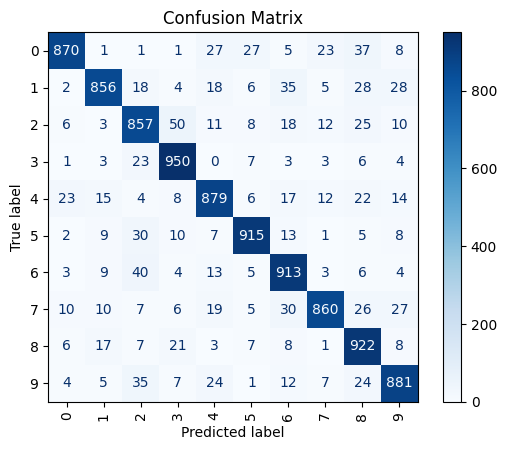

In [53]:
model = FCNN() 
model.load_state_dict(torch.load("best_FCNN_Adam.pth"))
model.to(device)
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in batch_test_set:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

In [54]:
test_accuracy = evaluate(model, batch_test_set, device)
print(f"test accuraccy: {test_accuracy}")

test accuraccy: 89.62339743589743
